<a href="https://colab.research.google.com/github/AntonPrazdnichnykh/dul_2021/blob/hw11/Homework/hw11/Homework11_selfsupervised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 414 (delta 108), reused 77 (delta 77), pack-reused 242
Receiving objects: 100% (414/414), 70.28 MiB | 25.12 MiB/s, done.
Resolving deltas: 100% (197/197), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=28255 sha256=6199f0b04d8ae9f3e9df63a44a326924ac9e73e32d58ed7730a0699c68778eb2
  Stored in directory: /tmp/pip-ephem-wheel-cache-lc8fzk_9/wheels/55/59/29/0fb1c635652157

In [2]:
from dul_2021.utils.hw11_utils import *

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchvision import transforms

import numpy as np
from copy import deepcopy
from tqdm import trange
from itertools import chain

In [4]:
from math import floor

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda')

In [9]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=28),
                                          transforms.RandomApply(torch.nn.ModuleList([
                                            transforms.ColorJitter(),
                                          ]), p=0.3),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [10]:
class Net(nn.Module):
    def __init__(self, in_channels, inp_size, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 16, 5, padding=2) 
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)  
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.conv_to_fc = self.compute_out_shape(inp_size)**2 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)

    @staticmethod
    def compute_out_shape(x):
      x = floor((x - 1) / 2 + 1)
      x = floor((x - 1) / 2 + 1)
      return x

    def forward(self, x):
    
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features


In [11]:
class MyDataset(Dataset):
  def __init__(self, data, transforms, n_views=2):
    self.data = data
    self.transforms = transforms
    self.n_views = n_views

  def __getitem__(self, idx):
    sample = self.data[idx][0]
    return torch.cat([self.transforms(sample) for _ in range(self.n_views)])

  def __len__(self):
    return len(self.data)

In [12]:
class BYOL(nn.Module):
  def __init__(self, latent_dim=128, hidden_dim=128, tau=0.99):
    super().__init__()
    self.enc = Net(1, 28, latent_dim, hidden_dim)
    self.mom_enc = Net(1, 28, latent_dim, hidden_dim)
    for p1, p2 in zip(self.enc.parameters(), self.mom_enc.parameters()):
      p2.data.copy_(p1.data)
      p2.requires_grad = False

    self.predictor = nn.Sequential(
        nn.Linear(latent_dim, 2 * latent_dim),
        nn.ReLU(),
        nn.Linear(2 * latent_dim, latent_dim)
    )
    self.tau = tau

  def update_momentum_weights(self):
    for p1, p2 in zip(self.enc.parameters(), self.mom_enc.parameters()):
      p2.data.copy_(self.tau * p2.data + (1 - self.tau) * p1.data)

  def cosine_distance(self, x_stud, x_teach):
    feats_orig = self.predictor(self.enc(x_stud))
    feats_contr = self.mom_enc(x_teach)
    return 1 - F.cosine_similarity(feats_orig, feats_contr)

  def loss(self, x):
    batch_size = x.size(0)
    x_stud, x_teach = x.chunk(2, dim=1)
    loss_1 = self.cosine_distance(x_stud, x_teach)
    loss_2 = self.cosine_distance(x_teach, x_stud)
    loss = loss_1 + loss_2
    return loss.mean()

  def fit(self, train_data, batch_size=512, lr=1e-4, num_epochs=20):
    train_data = MyDataset(train_data, transforms=contrast_transforms)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    optimizer = Adam(chain(self.enc.parameters(), self.predictor.parameters()), lr=lr)

    losses = []

    for epoch in trange(num_epochs, desc='Training'):
      for batch in dataloader:

        loss = self.loss(batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        self.update_momentum_weights()
        
        losses.append(loss.item())

    return np.array(losses)

    
  @torch.no_grad()
  def encode(self, batch):
    self.eval()
    out = self.enc(batch.to(device))
    self.train()
    return out


In [13]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    model = BYOL()
    model.to(device)
    losses = model.fit(train_data)
    return losses, model.encode


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Training: 100%|██████████| 20/20 [24:50<00:00, 74.52s/it]


mean classification accuracy=0.5040


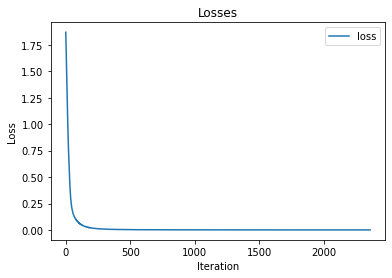

In [14]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=32),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [ ]:
class BarlowTwins(nn.Module):
  def __init__(self, latent_dim=128, hidden_dim=128, l_off_diag=0.01):
    super().__init__()
    self.net = Net(3, 32, latent_dim, hidden_dim)
    self.latent_dim = latent_dim
    self.l_off_diag = l_off_diag

  def loss(self, x):
    batch_size = x.size(0)
    x_a, x_b = x.chunk(2, dim=1)
    # print(x_a.shape, x_b.shape)
    z_a = self.net(x_a)
    z_b = self.net(x_b)

    z_a_norm = (z_a - z_a.mean(dim=0, keepdim=True)) / z_a.std(dim=0, keepdim=True)
    z_b_norm = (z_b - z_b.mean(dim=0, keepdim=True)) / z_b.std(dim=0, keepdim=True)

    c = z_a_norm.T.matmul(z_b_norm) / batch_size
    
    c_diff = (c - torch.eye(self.latent_dim, device=device)).pow(2)

    l_tensor = torch.ones_like(c_diff) * self.l_off_diag
    l_tensor[range(self.latent_dim), range(self.latent_dim)] = 1
    c_diff = c_diff * l_tensor
    return c_diff.sum()

  def fit(self, train_data, batch_size=512, lr=5e-4, num_epochs=20):
    train_data = MyDataset(train_data, transforms=contrast_transforms)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    optimizer = Adam(self.net.parameters(), lr=lr)

    losses = []

    for epoch in trange(num_epochs, desc='Training'):
      for batch in dataloader:

        loss = self.loss(batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

    return np.array(losses)

  @torch.no_grad()
  def encode(self, batch):
    self.eval()
    out = self.net(batch.to(device))
    self.train()
    return out

In [ ]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    model = BarlowTwins()
    model.to(device)
    losses = model.fit(train_data)
    return losses, model.encode


Files already downloaded and verified
Files already downloaded and verified


Training: 100%|██████████| 20/20 [20:02<00:00, 60.10s/it]


mean classification accuracy=0.3227


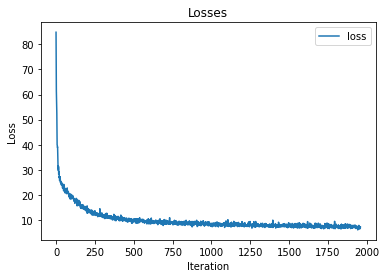

In [ ]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)